# Coffea-Casa Benchmark Example 1

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak

In [2]:
# This program plots an event-level variable (in this case, MET, but switching it is as easy as a dict-key change). It also demonstrates an easy use of the book-keeping cutflow tool, to keep track of the number of events processed.

# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class Processor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET", "MET [GeV]", 50, 0, 100)
        
        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        # This is where we do our actual analysis. The dataset has columns similar to the TTree's; events.columns can tell you them, or events.[object].columns for deeper depth.
        dataset = events.metadata["dataset"]
        MET = events.MET.pt
        
        # We can define a new key for cutflow (in this case 'all events'). Then we can put values into it. We need += because it's per-chunk (demonstrated below)
        output['cutflow']['all events'] += ak.size(MET)
        output['cutflow']['number of chunks'] += 1
        
        # This fills our histogram once our data is collected. The hist key ('MET=') will be defined in the bin in __init__.
        output['MET'].fill(dataset=dataset, MET=MET)
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client
import time

client = Client("tls://localhost:8786")

fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

output = processor.run_uproot_job(fileset,
                                treename = 'Events',
                                processor_instance = Processor(),
                                executor = processor.dask_executor,
                                executor_args = {'schema': processor.NanoAODSchema, 'client': client}
                                )

<AxesSubplot:xlabel='MET [GeV]', ylabel='Counts'>

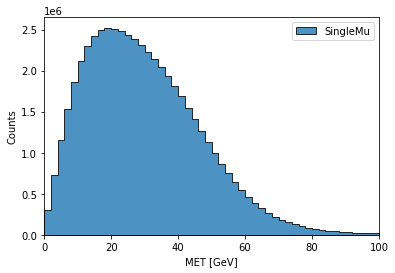

In [4]:
# Generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional, to fill the graph (default is a line).
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
# Easy way to print all cutflow dict values. Can just do print(output['cutflow']["KEY_NAME"]) for one.
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of chunks 534
